In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats
import joblib
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, f1_score, confusion_matrix, ConfusionMatrixDisplay
import shap
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
coffe = pd.read_csv("synthetic_coffee_health_10000.csv")
coffe.head()

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1


In [2]:
!pip install xgboost shap statsmodels

  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   --------- ------------------------------ 12.8/56.8 MB 64.1 MB/s eta 0:00:01
   -------------- ------------------------- 20.2/56.8 MB 51.7 MB/s eta 0:00:01
   ------------------ --------------------- 26.2/56.8 MB 42.4 MB/s eta 0:00:01
   ----------------------------- ---------- 42.2/56.8 MB 52.9 MB/s eta 0:00:01
   ---------------------------------------  56.6/56.8 MB 55.1 MB/s eta 0:00:01
   ---------------------------------------- 56.8/56.8 MB 51.7 MB/s  0:00:01
   ---------------------------------------- 0.0/545.1 kB ? eta -:--:--
   ---------------------------------------- 545.1/545.1 kB 40.1 MB/s  0:00:00
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 9.6/9.6 MB 63.9 MB/s  0:00:00
   ------------------------------

In [4]:
coffe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       10000 non-null  int64  
 1   Age                      10000 non-null  int64  
 2   Gender                   10000 non-null  object 
 3   Country                  10000 non-null  object 
 4   Coffee_Intake            10000 non-null  float64
 5   Caffeine_mg              10000 non-null  float64
 6   Sleep_Hours              10000 non-null  float64
 7   Sleep_Quality            10000 non-null  object 
 8   BMI                      10000 non-null  float64
 9   Heart_Rate               10000 non-null  int64  
 10  Stress_Level             10000 non-null  object 
 11  Physical_Activity_Hours  10000 non-null  float64
 12  Health_Issues            4059 non-null   object 
 13  Occupation               10000 non-null  object 
 14  Smoking                

In [6]:
coffe['Health_Issues'] = coffe['Health_Issues'].fillna('None')
coffe.describe()

,ID,Age,Coffee_Intake,Caffeine_mg,Sleep_Hours,BMI,Heart_Rate,Physical_Activity_Hours,Smoking,Alcohol_Consumption
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000
mean,5000.50000,34.949100,2.509230,238.411010,6.636220,23.986860,70.617800,7.48704,0.20040,0.300700
std,2886.89568,11.160939,1.450248,137.748815,1.222055,3.906411,9.822951,4.31518,0.40032,0.458585
min,1.00000,18.000000,0.000000,0.000000,3.000000,15.000000,50.000000,0.00000,0.00000,0.000000
25%,2500.75000,26.000000,1.500000,138.750000,5.800000,21.300000,64.000000,3.70000,0.00000,0.000000
50%,5000.50000,34.000000,2.500000,235.400000,6.600000,24.000000,71.000000,7.50000,0.00000,0.000000
75%,7500.25000,43.000000,3.500000,332.025000,7.500000,26.600000,77.000000,11.20000,0.00000,1.000000
max,10000.00000,80.000000,8.200000,780.300000,10.000000,38.200000,109.000000,15.00000,1.00000,1.000000


In [7]:
coffe.describe(include='object')

,Gender,Country,Sleep_Quality,Stress_Level,Health_Issues,Occupation
count,10000,10000,10000,10000,10000,10000
unique,3,20,4,3,4,5
top,Female,Canada,Good,Low,None,Office
freq,5001,543,5637,6989,5941,2073


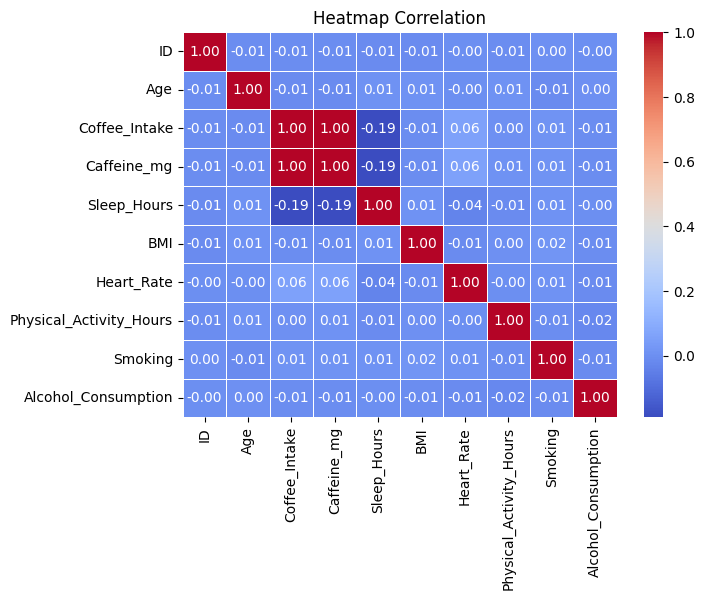

In [8]:
coffe_numeric = coffe.select_dtypes(include=['number'])

# Calculate correlation
corr_matrix = coffe_numeric.corr()

# Plot heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap Correlation")
plt.show()

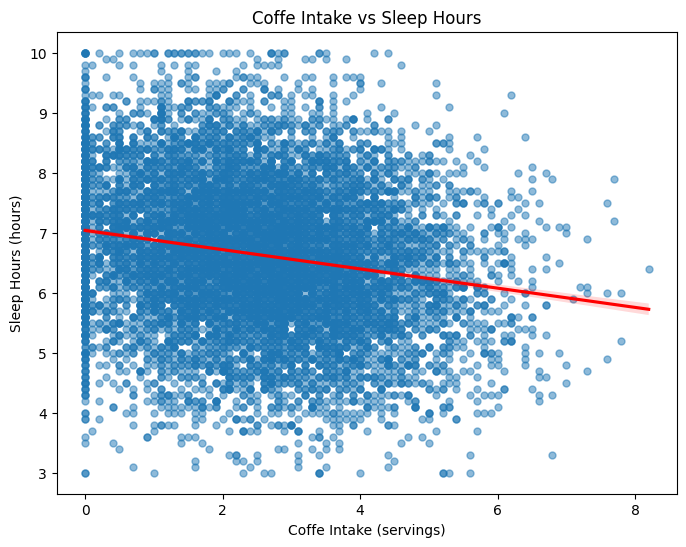

In [9]:
plt.figure(figsize=(8, 6))
sns.regplot(
    x="Coffee_Intake",
    y="Sleep_Hours",
    data=coffe,
    scatter_kws={"s": 25, "alpha": 0.5},
    line_kws={"color": "red"}
)
plt.title("Coffe Intake vs Sleep Hours")
plt.xlabel("Coffe Intake (servings)")
plt.ylabel("Sleep Hours (hours)")
plt.show()

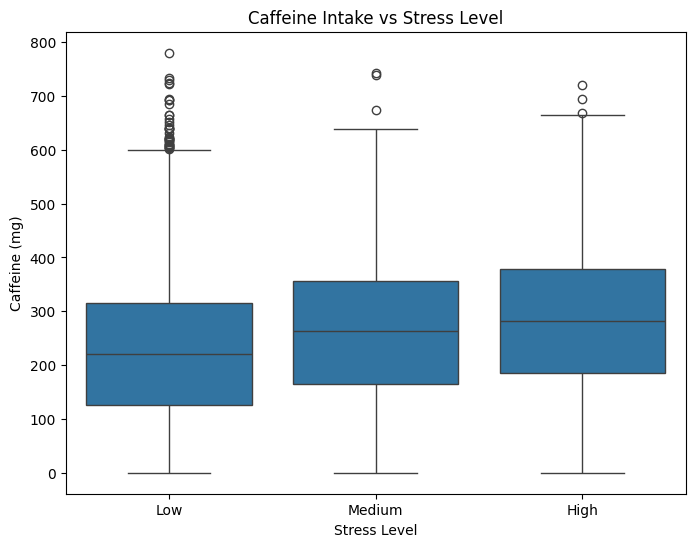

In [10]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Stress_Level', y='Caffeine_mg', data=coffe)
plt.title('Caffeine Intake vs Stress Level')
plt.xlabel('Stress Level')
plt.ylabel('Caffeine (mg)')
plt.show()

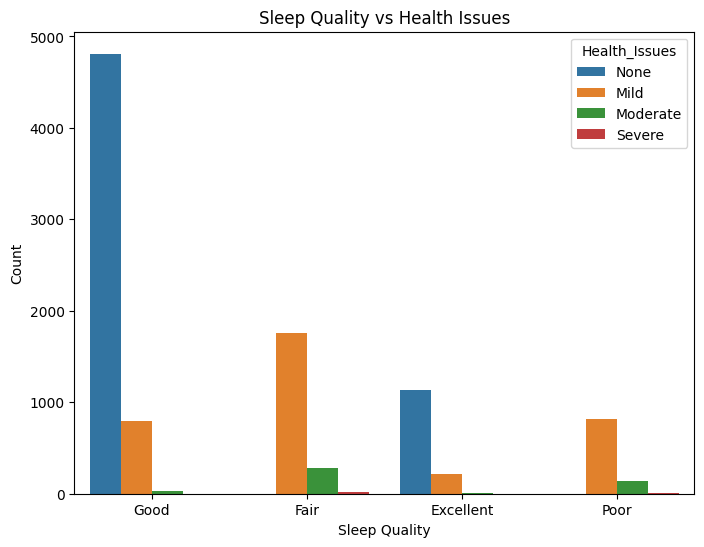

In [11]:
plt.figure(figsize=(8, 6))
sns.countplot(data=coffe, x='Sleep_Quality', hue='Health_Issues')
plt.title('Sleep Quality vs Health Issues')
plt.xlabel('Sleep Quality')
plt.ylabel('Count')
plt.show()

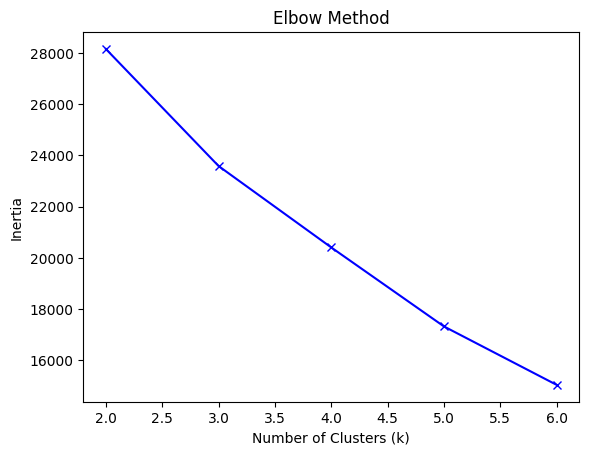

In [12]:
# Select features for clustering
features = ["Coffee_Intake", "Sleep_Hours", "BMI", "Stress_Level", "Sleep_Quality"]
coffe_cluster = coffe[features].copy()

# Encode category ordinal
ordinal_maps = {
    "Stress_Level": {"Low": 0, "Medium": 1, "High": 2},
    "Sleep_Quality": {"Poor": 0, "Fair": 1, "Good": 2, "Excellent": 3}
}

for col, mapping in ordinal_maps.items():
    coffe_cluster[col] = coffe_cluster[col].map(mapping)

# Normalization
scaler = StandardScaler()
scaled_data = scaler.fit_transform(coffe_cluster)

# Find the optimal number of clusters (Elbow Method)
inertia = []
K = range(2, 7)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bx-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

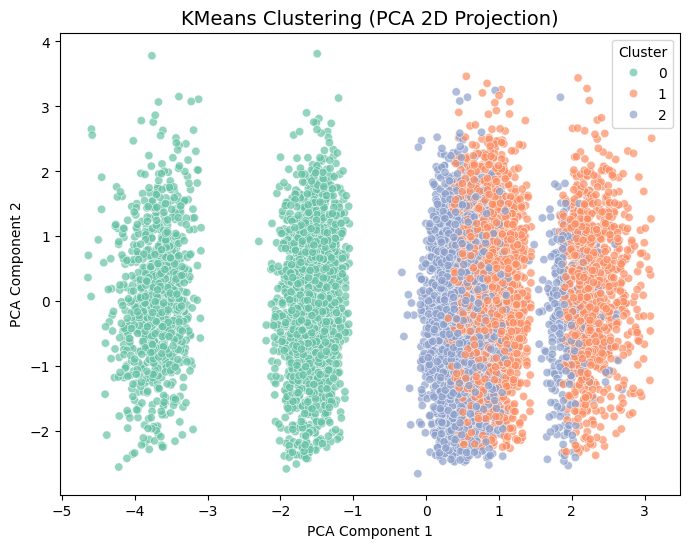

         Coffee_Intake  Sleep_Hours        BMI  Stress_Level  Sleep_Quality
Cluster                                                                    
0             2.832780     5.217735  23.974859      1.319163       0.680837
1             1.287808     7.488030  24.228983      0.000000       2.285952
2             3.525178     6.990325  23.739024      0.000000       2.094675


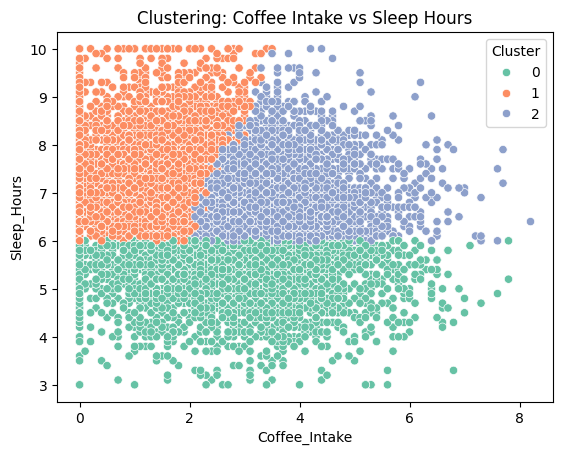

In [13]:
# Fit clustering (chose k=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to the original dataframe
coffe["Cluster"] = cluster_labels

# PCA reduksi ke 2 dimensi
pca = PCA(n_components=2, random_state=42)
pca_data = pca.fit_transform(scaled_data)
coffe["PCA1"] = pca_data[:, 0]
coffe["PCA2"] = pca_data[:, 1]

# Plot PCA hasil clustering
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="PCA1", y="PCA2",
    hue="Cluster", data=coffe,
    palette="Set2", alpha=0.7
)

plt.title("KMeans Clustering (PCA 2D Projection)", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()
# Create coffe_cluster dataframe with encoded features and cluster labels
features = ["Coffee_Intake", "Sleep_Hours", "BMI", "Stress_Level", "Sleep_Quality"]
coffe_cluster = coffe[features].copy()

ordinal_maps = {
    "Stress_Level": {"Low": 0, "Medium": 1, "High": 2},
    "Sleep_Quality": {"Poor": 0, "Fair": 1, "Good": 2, "Excellent": 3}
}

for col, mapping in ordinal_maps.items():
    coffe_cluster[col] = coffe_cluster[col].map(mapping)

coffe_cluster["Cluster"] = cluster_labels


# Cluster results analysis
numeric_and_encoded_features = ["Coffee_Intake", "Sleep_Hours", "BMI", "Stress_Level", "Sleep_Quality"]
cluster_summary = coffe_cluster.groupby("Cluster")[numeric_and_encoded_features].mean()
print(cluster_summary)

# Visualisasi Coffee Intake vs Sleep Hours
sns.scatterplot(
    x="Coffee_Intake", y="Sleep_Hours",
    hue="Cluster", data=coffe_cluster, palette="Set2"
)
plt.title("Clustering: Coffee Intake vs Sleep Hours")
plt.show()

In [14]:
# Search for the group “coffee addicts who sleep poorly”
coffee_addict_cluster = cluster_summary[
    (cluster_summary["Coffee_Intake"] > coffe["Coffee_Intake"].mean()) &
    (cluster_summary["Sleep_Hours"] < coffe["Sleep_Hours"].mean()) &
    (cluster_summary["Stress_Level"] > 0)  # Medium/High
]
print("\nCluster Potential coffee addicts who don't sleep well:\n", coffee_addict_cluster)


Cluster Potential coffee addicts who don't sleep well:
          Coffee_Intake  Sleep_Hours        BMI  Stress_Level  Sleep_Quality
Cluster                                                                    
0              2.83278     5.217735  23.974859      1.319163       0.680837


### Fuction for feature engineering

In [16]:
# Function for feature engineering
def engineer_features(df):
    """
    Performing feature engineering on the training and test sets
    """
    
    age_bins = [0, 30, 40, 50, 60, 100]
    age_labels = ['18-29', '30-39', '40-49', '50-59', '60+']
    df['Age_Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels)
    
    # BMI Categorization
    bmi_bins = [0, 18.5, 25, 30, 35, 40, 100]
    bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese_I', 'Obese_II', 'Obese_III']
    df['BMI_Category'] = pd.cut(df['BMI'], bins=bmi_bins, labels=bmi_labels)
    
    # Sleep Hours Categorization
    sleep_bins = [0, 6, 7, 9, 24]
    sleep_labels = ['Deficit', 'Low', 'Recommended', 'Long']
    df['Sleep_Category'] = pd.cut(df['Sleep_Hours'], bins=sleep_bins, labels=sleep_labels)
    
    # 3. Creating New Features
    # Caffeine per Cup
    df['Caffeine_Per_Cup'] = df['Caffeine_mg'] / df['Coffee_Intake'].replace(0, 1)
    
    # Interaction Features
    df['BMI_Activity_Interaction'] = df['BMI'] * df['Physical_Activity_Hours']
    
    df['Caffeine_Sleep_Interaction'] = df['Caffeine_mg'] * df['Sleep_Hours']
    
    return df

# Apply feature engineering
coffe_eng = engineer_features(coffe)

### Preparation Data

In [17]:
# 1. Define which features are categorical and which are targets
feature_categorical = ["Gender", "Country", "Occupation", "Age_Group", "BMI_Category", "Sleep_Category"]
target_categorical = ["Stress_Level", "Sleep_Quality", "Health_Issues"]

coffe_encoded = coffe_eng.copy()
encoders = {"features": {}, "targets": {}}

# 2. Encode fitur
for col in feature_categorical:
    le = LabelEncoder()
    coffe_encoded[col] = le.fit_transform(coffe_encoded[col])
    encoders["features"][col] = le

# 3. Encode target
for col in target_categorical:
    le = LabelEncoder()
    coffe_encoded[col] = le.fit_transform(coffe_encoded[col])
    encoders["targets"][col] = le

joblib.dump(encoders, "encoders.pkl")

['encoders.pkl']

In [18]:
# Features & Targets
X = coffe_encoded.drop(columns=["Sleep_Quality", "Stress_Level", "Health_Issues", "ID", "PCA1", "PCA2", "Cluster"])
y_sleep = coffe_encoded["Sleep_Quality"]
y_stress = coffe_encoded["Stress_Level"]
y_health = coffe_encoded["Health_Issues"]

feature_cols = X.columns.tolist()
joblib.dump(feature_cols, "feature_cols.pkl")

['feature_cols.pkl']

In [19]:
# Split data
X_train, X_test, y_sleep_train, y_sleep_test = train_test_split(X, y_sleep, test_size=0.2, random_state=42, stratify=y_sleep)
X_train, X_test, y_stress_train, y_stress_test = train_test_split(X, y_stress, test_size=0.2, random_state=42, stratify=y_stress)
X_train, X_test, y_health_train, y_health_test = train_test_split(X, y_health, test_size=0.2, random_state=42, stratify=y_health)

In [20]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

## Modeling
###  1. Sleep Quality

In [21]:
param_grid_sleep = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Count the number of classes from the target
num_classes_sleep = len(np.unique(y_sleep_train))

model_xgb_sleep = xgb.XGBClassifier(
    objective='multi:softprob',   
    num_class=num_classes_sleep,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss"       
)

grid_search_sleep = GridSearchCV(
    model_xgb_sleep,
    param_grid_sleep,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)

grid_search_sleep.fit(X_train, y_sleep_train)

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:54:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,estimator,"XGBClassifier..._class=4, ...)"
,param_grid,"{'colsample_bytree': [0.7, 0.8, ...], 'learning_rate': [0.001, 0.01, ...], 'max_depth': [3, 5, ...], 'n_estimators': [200, 300, ...], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'multi:softprob'


In [22]:
best_model_sleep = grid_search_sleep.best_estimator_
y_pred_sleep = best_model_sleep.predict(X_test)

# Softprob = probability per class
y_pred_sleep_proba = best_model_sleep.predict_proba(X_test) 
roc_auc_sleep = roc_auc_score(y_sleep_test, y_pred_sleep_proba, multi_class="ovr", average="macro")

print("Accuracy:", accuracy_score(y_sleep_test, y_pred_sleep))
print("Report Classification:")
print(classification_report(y_sleep_test, y_pred_sleep))
print("ROC-AUC Score:", roc_auc_sleep)

joblib.dump(best_model_sleep, "xgb_best_model_sleep.pkl")

Accuracy: 0.564
Report Classification:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       270
           1       0.00      0.00      0.00       410
           2       0.56      1.00      0.72      1128
           3       0.00      0.00      0.00       192

    accuracy                           0.56      2000
   macro avg       0.14      0.25      0.18      2000
weighted avg       0.32      0.56      0.41      2000

ROC-AUC Score: 0.5015530933390285


c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

['xgb_best_model_sleep.pkl']

                       Feature  Importance
6                          BMI      2119.0
15            Caffeine_Per_Cup      1987.0
0                          Age      1830.0
5                  Sleep_Hours      1816.0
16    BMI_Activity_Interaction      1813.0
7                   Heart_Rate      1671.0
8      Physical_Activity_Hours      1638.0
17  Caffeine_Sleep_Interaction      1472.0
2                      Country      1365.0
4                  Caffeine_mg      1036.0
3                Coffee_Intake      1008.0
9                   Occupation       655.0
1                       Gender       266.0
13                BMI_Category       249.0
11         Alcohol_Consumption       236.0
10                     Smoking       196.0
12                   Age_Group       181.0
14              Sleep_Category       144.0


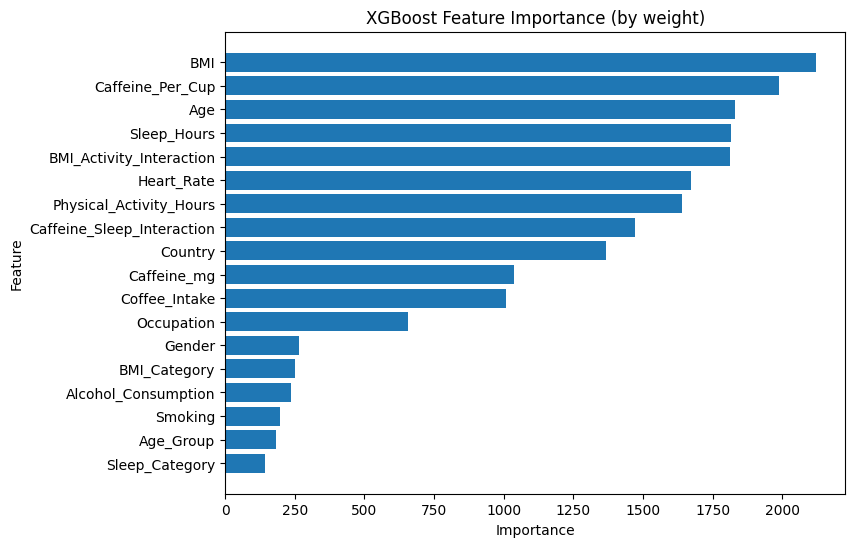

In [23]:
feature_names = X.columns.tolist()
booster_sleep = best_model_sleep.get_booster()

importance_dict_sleep = booster_sleep.get_score(importance_type='weight')

importance_df_sleep = pd.DataFrame({
    'Feature': [feature_names[int(f[1:])] for f in importance_dict_sleep.keys()],
    'Importance': list(importance_dict_sleep.values())
}).sort_values(by="Importance", ascending=False)

print(importance_df_sleep)

plt.figure(figsize=(8,6))
plt.barh(importance_df_sleep['Feature'], importance_df_sleep['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance (by weight)")
plt.show()

### 2. Stress Level

In [24]:
param_grid_stress = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Count the number of classes from the target
num_classes_stress = len(np.unique(y_stress_train))

model_xgb_stress = xgb.XGBClassifier(
    objective='multi:softprob',   
    num_class=num_classes_stress,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss"       
)

grid_search_stress = GridSearchCV(
    model_xgb_stress,
    param_grid_stress,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)

grid_search_stress.fit(X_train, y_stress_train)

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:58:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,estimator,"XGBClassifier..._class=3, ...)"
,param_grid,"{'colsample_bytree': [0.7, 0.8, ...], 'learning_rate': [0.001, 0.01, ...], 'max_depth': [3, 5, ...], 'n_estimators': [200, 300, ...], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'multi:softprob'


In [25]:
best_model_stress = grid_search_stress.best_estimator_
y_pred_stress = best_model_stress.predict(X_test)

# Softprob = probability per class
y_pred_stress_proba = best_model_stress.predict_proba(X_test) 
roc_auc_stress = roc_auc_score(y_stress_test, y_pred_stress_proba, multi_class="ovr", average="macro")

print("Accuracy:", accuracy_score(y_stress_test, y_pred_stress))
print("Report Classification:")
print(classification_report(y_stress_test, y_pred_stress))
print("ROC-AUC Score:", roc_auc_stress)

joblib.dump(best_model_sleep, "xgb_best_model_stress.pkl")

Accuracy: 0.699
Report Classification:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       192
           1       0.70      1.00      0.82      1398
           2       0.00      0.00      0.00       410

    accuracy                           0.70      2000
   macro avg       0.23      0.33      0.27      2000
weighted avg       0.49      0.70      0.58      2000

ROC-AUC Score: 0.50803023200438


c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

['xgb_best_model_stress.pkl']

                       Feature  Importance
6                          BMI       535.0
5                  Sleep_Hours       513.0
15            Caffeine_Per_Cup       429.0
8      Physical_Activity_Hours       389.0
16    BMI_Activity_Interaction       373.0
0                          Age       349.0
3                Coffee_Intake       248.0
17  Caffeine_Sleep_Interaction       241.0
7                   Heart_Rate       216.0
4                  Caffeine_mg       200.0
2                      Country       185.0
9                   Occupation        76.0
12                   Age_Group        49.0
10                     Smoking        48.0
11         Alcohol_Consumption        38.0
13                BMI_Category        32.0
1                       Gender        31.0
14              Sleep_Category        25.0


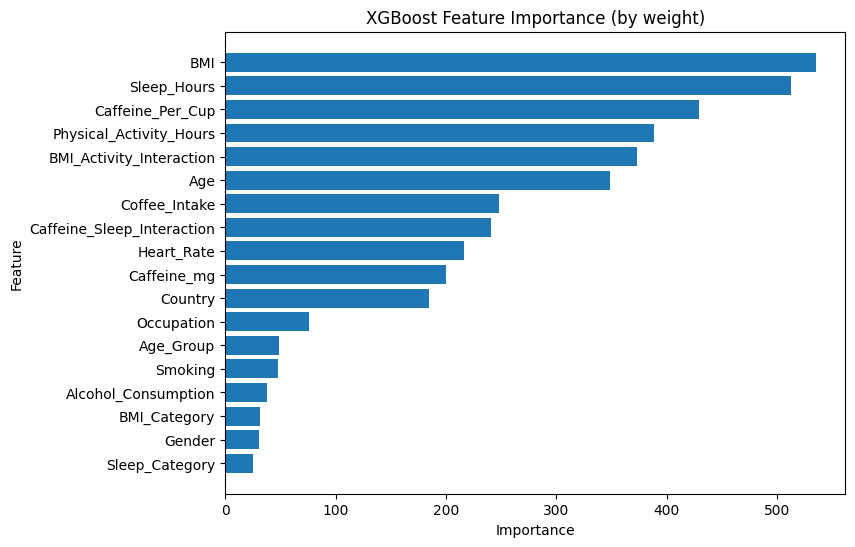

In [26]:
feature_names = X.columns.tolist()
booster_stress = best_model_stress.get_booster()

importance_dict_stress = booster_stress.get_score(importance_type='weight')

importance_df_stress = pd.DataFrame({
    'Feature': [feature_names[int(f[1:])] for f in importance_dict_stress.keys()],
    'Importance': list(importance_dict_stress.values())
}).sort_values(by="Importance", ascending=False)

print(importance_df_stress)

plt.figure(figsize=(8,6))
plt.barh(importance_df_stress['Feature'], importance_df_stress['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance (by weight)")
plt.show()

### 3. Health Issues

In [27]:
param_grid_health = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Count the number of classes from the target
num_classes_health = len(np.unique(y_health_train))

model_xgb_health = xgb.XGBClassifier(
    objective='multi:softprob',   
    num_class=num_classes_health,
    random_state=101,
    use_label_encoder=False,
    eval_metric="mlogloss"       
)

grid_search_health = GridSearchCV(
    model_xgb_health,
    param_grid_health,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)

grid_search_health.fit(X_train, y_health_train)

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:00:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,estimator,"XGBClassifier..._class=4, ...)"
,param_grid,"{'colsample_bytree': [0.7, 0.8, ...], 'learning_rate': [0.001, 0.01, ...], 'max_depth': [3, 5, ...], 'n_estimators': [200, 300, ...], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'multi:softprob'


In [28]:
best_model_health = grid_search_health.best_estimator_
y_pred_health = best_model_health.predict(X_test)

# Softprob = probability per class
y_pred_health_proba = best_model_health.predict_proba(X_test) 
roc_auc_health = roc_auc_score(y_health_test, y_pred_health_proba, multi_class="ovr", average="macro")

print("Accuracy:", accuracy_score(y_health_test, y_pred_health))
print("Report Classification:")
print(classification_report(y_health_test, y_pred_health))
print("ROC-AUC Score:", roc_auc_health)

joblib.dump(best_model_sleep, "xgb_best_model_health.pkl")

Accuracy: 0.985
Report Classification:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       716
           1       0.97      0.94      0.95        93
           2       0.99      0.99      0.99      1188
           3       1.00      1.00      1.00         3

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000

ROC-AUC Score: 0.9997582069535836


['xgb_best_model_health.pkl']

                       Feature  Importance
6                          BMI      1595.0
0                          Age      1151.0
15            Caffeine_Per_Cup       882.0
5                  Sleep_Hours       873.0
7                   Heart_Rate       635.0
8      Physical_Activity_Hours       607.0
2                      Country       585.0
16    BMI_Activity_Interaction       578.0
17  Caffeine_Sleep_Interaction       420.0
4                  Caffeine_mg       353.0
3                Coffee_Intake       320.0
9                   Occupation       237.0
13                BMI_Category       141.0
14              Sleep_Category       110.0
1                       Gender        99.0
12                   Age_Group        64.0
11         Alcohol_Consumption        62.0
10                     Smoking        35.0


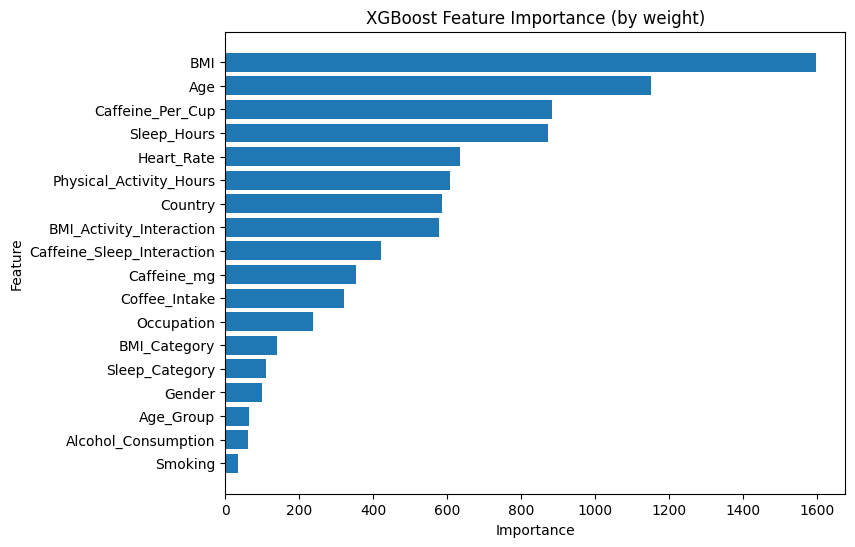

In [29]:
feature_names = X.columns.tolist()
booster_health = best_model_health.get_booster()

importance_dict_health = booster_health.get_score(importance_type='weight')

importance_df_health = pd.DataFrame({
    'Feature': [feature_names[int(f[1:])] for f in importance_dict_health.keys()],
    'Importance': list(importance_dict_health.values())
}).sort_values(by="Importance", ascending=False)

print(importance_df_health)

plt.figure(figsize=(8,6))
plt.barh(importance_df_health['Feature'], importance_df_health['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance (by weight)")
plt.show()

## Evaluation
### 1. Sleep Quality

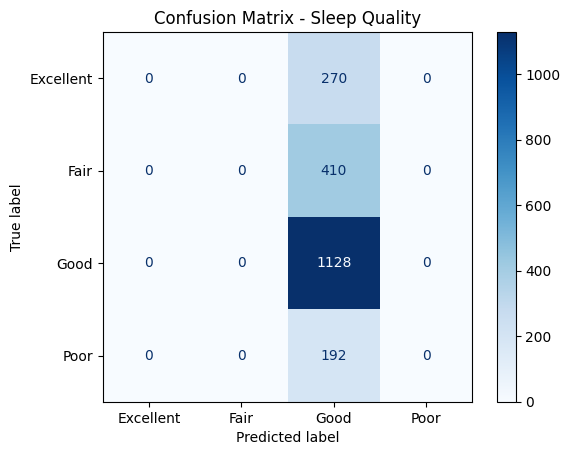

In [30]:
cm_sleep = confusion_matrix(y_sleep_test, y_pred_sleep)

# Plot with original labels
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_sleep,
    display_labels=encoders["targets"]["Sleep_Quality"].classes_
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Sleep Quality")
plt.show()

## 2. Stress Level

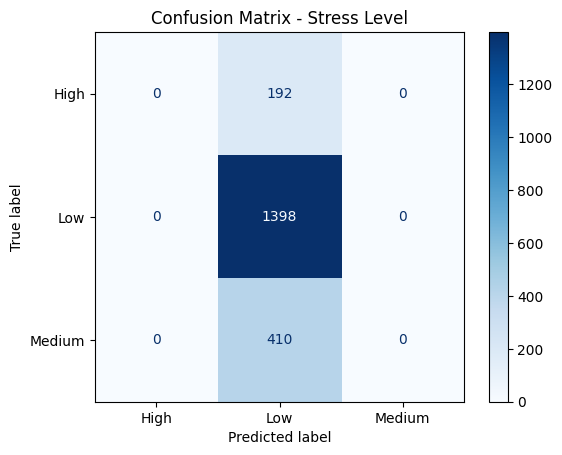

In [31]:
cm_stress = confusion_matrix(y_stress_test, y_pred_stress)

# Plot with original labels
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_stress,
    display_labels=encoders["targets"]["Stress_Level"].classes_
)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Stress Level")
plt.show()

###  3. Health Issues

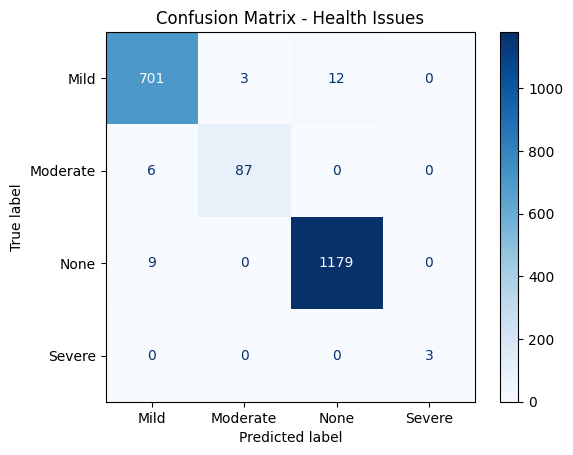

In [32]:
cm_health = confusion_matrix(y_health_test, y_pred_health)

# Plot with original labels
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_health,
    display_labels=encoders["targets"]["Health_Issues"].classes_
)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Health Issues")
plt.show()